## Particle within radius or overlap calculations

In [1]:
#user-defined
# import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

In [2]:
dir_save = '../../data/Sprints/AN/'
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/Run03/Set05/wind05Run03_InterpolatedX.hdf'
df = pd.read_hdf(dir)

### Calculate Expected encounters

In [3]:
# df=pd.concat([df1,df2,df3]).reset_index(drop=True)

In [4]:
# df = pd.DataFrame()
# df = pd.read_hdf(dir)
dt= df.master_time[1]-df.master_time[0]

In [5]:
sync_time = df.master_time-df.master_time[0]
df.insert(1,'sync_time',sync_time)

In [6]:
# storing the odor location in a numpy array to avoid reading pandas
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 
source = np.array([[0,0]])
distance_from_source = np.array([cdist(odor_position,source)]).flatten()

### Finding Intersection area

In [7]:
# from scipy.spatial import cKDTree

# # Assuming a default tolerance value of 1 here
# def intersect_close(a, b, tol=0.05):
#     # Get closest distances for each pt in b
#     dist, index = cKDTree(a).query(b, k=1) # k=1 selects closest one neighbor

#     # Check the distances against the given tolerance value and 
#     # thus filter out rows off b for the final output
#     return b[dist <= tol], index

In [8]:
# c1 = np.column_stack((e1, n1))
# c2 = np.column_stack((e2, n2))
# test,index = intersect_close(c1,c2)
# print(test)
# a,b=zip(*test)

# Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

For stationery wind sensor: The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2

In [129]:
m = []
a = np.array([[9,0],[6,0],[5,0],[4,0],[3,0],[2,0],[1,0]])
b = np.array([[7,0]])
dis = cdist(b,a).flatten()
print('distance', dis)
print(np.where(dis == np.amin(dis)))
n = len(a)
x = [a[i][0] for i in range(n)]
y = [a[i][1] for i in range(n)]
# x,y = zip(*a)
start = time.time()
print(pathlength(x, y))
time.time()-start
# dis=dis.flatten()
# print(dis)
# min(dis)


distance [2. 1. 2. 3. 4. 5. 6.]
(array([1]),)


In [157]:
a = np.array([[1,0],[0,1]])
n = len(a)
x = [a[i][0] for i in range(n)]
y = [a[i][1] for i in range(n)]
# x,y = zip(*a)
start = time.time()
print(pathlength(x, y))
time.time()-start

1.4142135623730951


0.0003521442413330078

In [ ]:
#     pos = np.where(distance == np.amin(distance))
#     dist_to_measure.append(wind_pos[-(len(wind_pos)-pos):])
#     wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T  


In [163]:
eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df)) ]
northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]


In [164]:
# s = time.time()
odor_presence=[]
points_along_streakline = []
nearest_particle= []
#for(upper, lower, step)
for i in range((len(eastwest))-1, 6000, -1):
    
    odor_pos = [odor_position[i]]  
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
    radius = np.arange(start = 6000, stop = 0, step = -1)**0.5*0.01

    distance = cdist(odor_pos,wind_pos).flatten()   # cdist compares distance for all the points in both arrays
    nearest_particle.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))
#     loc = len(wind_pos)-pos[0]
    points_along_streakline.append(wind_pos[int(pos[0]):])
    
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)
# print(time.time()-s)




In [165]:
# s = time.time()
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        radius = np.arange(start = i, stop = 0, step = -1)**0.5*0.01
    
    distance = cdist(odor_pos,wind_pos).flatten()   # cdist compares distance for all the points in both arrays
    nearest_particle.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))
#     loc = len(wind_pos)-pos[0]
    points_along_streakline.append(wind_pos[int(pos[0]):])
        
    x = np.any(distance<=radius)             # generates a boolean values 
    if x==True:
        odor_presence.append(1)
    else:
        odor_presence.append(0)

# print(time.time()-s)


In [166]:
# def pathlength(x,y):
#     n = len(x) 
#     lv = [np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) for i in range (1,n)]
#     L = sum(lv)
#     return L

In [167]:
distance_along_streakline=[]
for i in range(len(points_along_streakline)):
    lengths = np.sqrt(np.sum(np.diff(np.array(points_along_streakline[i]), axis=0)**2, axis=1)) # Length between corners
    distance_along_streakline.append(np.sum(lengths))

In [168]:
## flip containers because above iteration is done in reverse order
df['mock'] = np.zeros(len(df))
distance_along_streakline = np.array(np.flip(distance_along_streakline)) 
odor_presence = odor_presence[::-1]
max_radius = max_radius[::-1]

## storing in the dataframe 
df['odor_expected'] = odor_presence
df['distance_along_streakline'] =  distance_along_streakline
df['nearest_particle'] = nearest_particle

# sensor_direction = np.array(np.arctan2(df.gps_linear_y,df.gps_linear_x)* 180 / np.pi)
# df['relative_motion']=sensor_direction - df.D


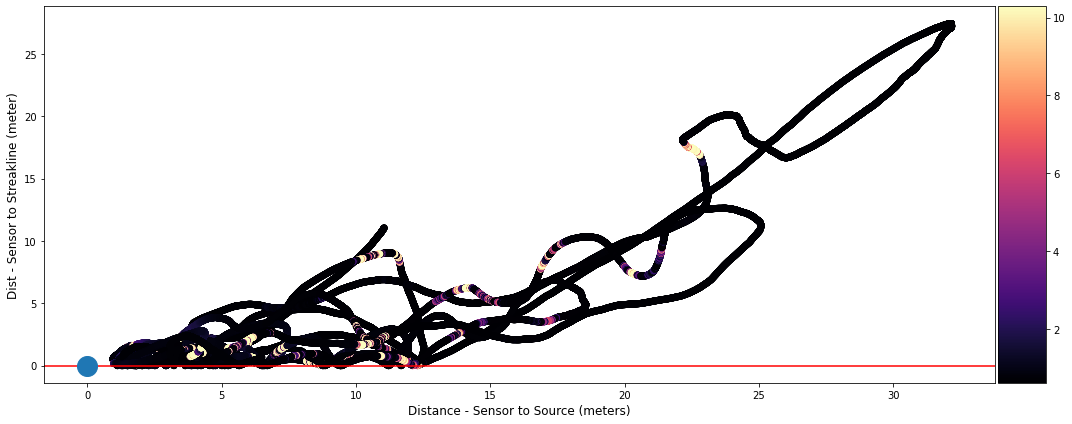

In [59]:
f, ax = plt.subplots(1,1, figsize =(15,6))

# ax.set_xlabel('Avg Distance from Sensor (m)', fontsize = 12)
# ax.set_ylabel('Avg Distance from Streakline (m)', fontsize = 12)
# var2 = ax.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'magma', extent=[x[0], x[-1], y[0], y[-1]])
# start, end = ax.get_xlim()
ax.axhline(0, color = 'red')
ax.plot(0,0,'o', markersize = 20)

ax.set_xlabel('Distance - Sensor to Source (meters)' , fontsize = 12)
ax.set_ylabel('Dist - Sensor to Streakline (meter)' , fontsize = 12)
var =ax.scatter(df.odor_from_source, df.odor_from_wind, c=df.odor, cmap='magma')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()

In [169]:
df.keys()

Index(['master_time', 'sync_time', 'xsrc', 'ysrc', 'odor', 'trisonica_u',
       'trisonica_v', 'trisonica_pressure', 'trisonica_temperature',
       'gps_linear_x', 'gps_linear_y', 'gps_linear_z', 'imu_angular_x',
       'imu_angular_y', 'imu_angular_z', 'imu_linear_acc_x',
       'imu_linear_acc_y', 'imu_linear_acc_z', 'U', 'V', 'D', 'S2', 'mock',
       'odor_expected', 'odor_from_wind', 'odor_from_source',
       'distance_along_streakline', 'nearest_particle'],
      dtype='object')

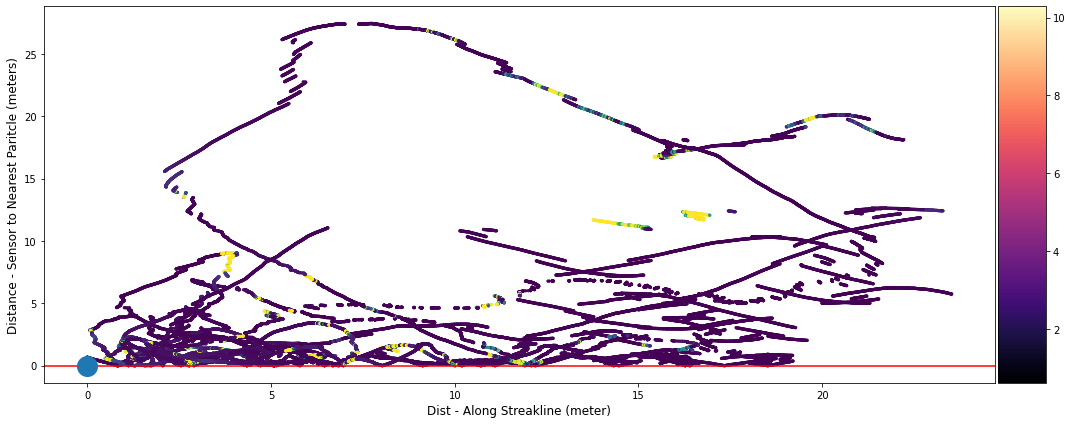

In [177]:
f, ax = plt.subplots(1,1, figsize =(15,6))

# ax.set_xlabel('Avg Distance from Sensor (m)', fontsize = 12)
# ax.set_ylabel('Avg Distance from Streakline (m)', fontsize = 12)
# var2 = ax.imshow(Encounters, interpolation='nearest', origin='lower',cmap = 'magma', extent=[x[0], x[-1], y[0], y[-1]])
# start, end = ax.get_xlim()
ax.axhline(0, color = 'red')
ax.plot(0,0,'o', markersize = 20)

ax.set_xlabel('Dist - Along Streakline (meter)' , fontsize = 12)
ax.set_ylabel('Distance - Sensor to Nearest Paritcle (meters)' , fontsize = 12)
var =ax.scatter(df.distance_along_streakline, df.nearest_particle, c=df.odor, cmap='viridis', s=5)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(var2, cax=cax, orientation = 'vertical')

f.tight_layout()

## Visualization

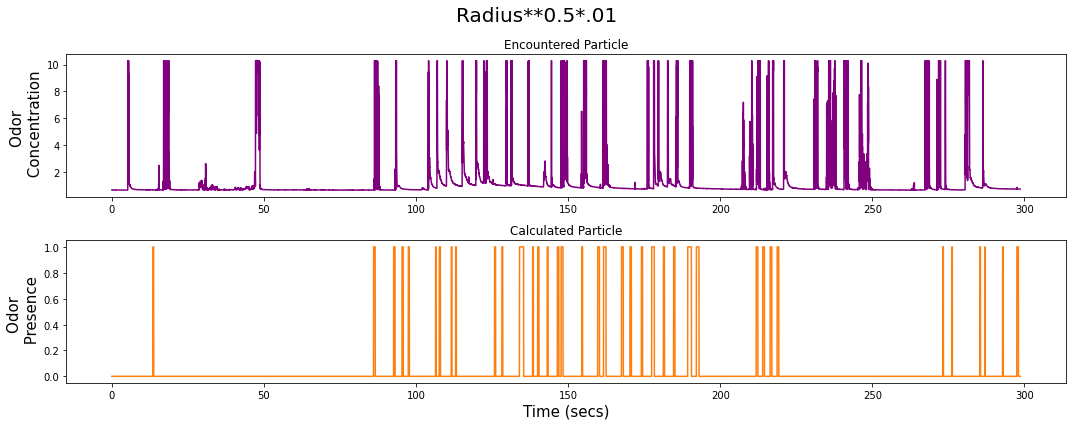

In [13]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(15,6))
# ax1.set_prop_cycle('color',[plt.cm.OrRd(i) for i in df.odor])

# ax1.set_facecolor('black')
ax1.plot(df.sync_time, df.odor, color='Purple')
ax1.set_ylabel('Odor \n Concentration', fontsize=15)
ax1.title.set_text('Encountered Particle')
ax2.plot(df.sync_time,df.odor_expected, color='C1')
ax2.set_xlabel('Time (secs)', fontsize=15)
ax2.set_ylabel('Odor \n Presence', fontsize=15)
ax2.title.set_text('Calculated Particle')

f.suptitle('Radius**0.5*.01', fontsize =20)
f.tight_layout()

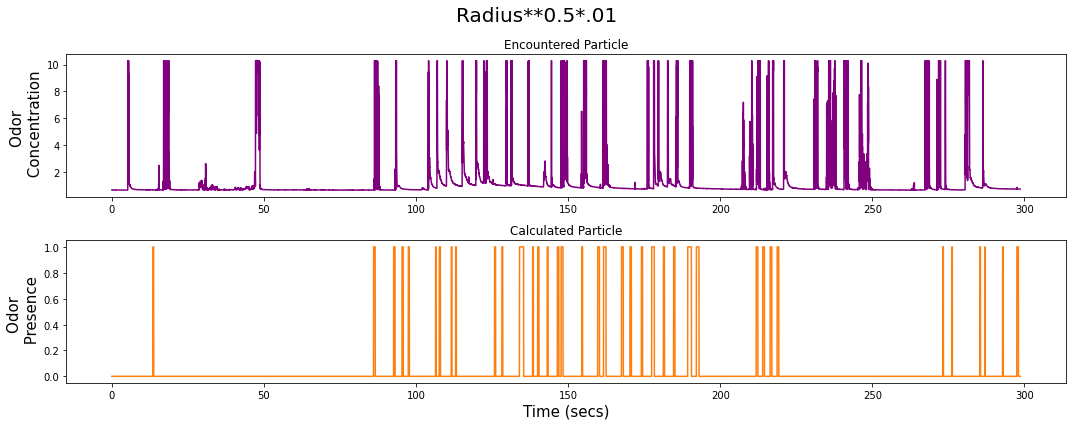

In [197]:
f, (ax1,ax2) = plt.subplots(2, 1,figsize=(15,6))
# ax1.set_prop_cycle('color',[plt.cm.OrRd(i) for i in df.odor])

# ax1.set_facecolor('black')
a
ax1.plot(df.sync_time, df.odor, color='Purple')
ax1.set_ylabel('Odor \n Concentration', fontsize=15)
ax1.title.set_text('Encountered Particle')
ax2.plot(df.sync_time,df.odor_expected, color='C1')
ax2.set_xlabel('Time (secs)', fontsize=15)
ax2.set_ylabel('Odor \n Presence', fontsize=15)
ax2.title.set_text('Calculated Particle')

f.suptitle('Radius**0.5*.01', fontsize =20)
f.tight_layout()